### Setup and Helper Functions 🛠️

This first cell imports all the necessary libraries and defines the core helper functions. It establishes the file paths, the compute_local_variance function, and the score_to_class function, which converts the continuous subjective scores into one of three discrete classes for classification analysis.

In [18]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np
import cv2
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from torch.nn import GroupNorm
from sklearn.metrics import accuracy_score, confusion_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paths & Directories ---
konjnd_patches_dir = "KonJND-1k/patches_blend"
samsung_dataset_dir = "Samsung/dataset"
konjnd_json_path = os.path.join(konjnd_patches_dir, "metadata.json")

# --- Helper: compute local variance ---
def compute_local_variance(img, patch_size):
    """
    Computes the local variance of an image using a sliding window.
    This is used as an additional feature channel for the model.
    """
    # Convert image to grayscale and float32 for computation
    gray = np.array(img.convert("L"), dtype=np.float32)
    # Create a kernel for the mean filter
    kernel = np.ones((patch_size, patch_size), np.float32) / (patch_size**2)
    # Compute the local mean and squared mean using 2D convolution
    mean = cv2.filter2D(gray, -1, kernel)
    mean_sq = cv2.filter2D(gray**2, -1, kernel)
    # The variance is calculated as E[x^2] - (E[x])^2
    variance = mean_sq - mean**2
    return variance

# --- Helper: Convert score to classification bin ---
def score_to_class(score):
    """
    Converts a continuous score (0 to 1) into a discrete class (0, 1, or 2).
    - Class 0: Low (score < 0.33)
    - Class 1: Medium (0.33 <= score < 0.66)
    - Class 2: High (score >= 0.66)
    """
    if score < 0.33:
        return 0  # Low quality
    elif score < 0.66:
        return 1  # Medium quality
    else:
        return 2  # High quality

print("Setup complete. Helper functions and paths defined.")

Setup complete. Helper functions and paths defined.


### Dataset Classes 📂

This cell defines the two custom PyTorch Dataset classes, ImagePairDataset for the KonJND-1k dataset and SamsungDataset for the Samsung dataset. These classes handle the loading, preprocessing, and feature engineering (like stacking clean, distorted, difference, and variance maps) for the model.

In [19]:
# -----------------------------
# Dataset classes
# -----------------------------
class ImagePairDataset(Dataset):
    """
    A custom PyTorch Dataset for the KonJND-1k dataset.
    Loads pairs of clean and distorted images, computes a difference map
    and local variance map, and stacks them for model input.
    """
    def __init__(self, json_path, images_dir, transform=None):
        if not os.path.exists(json_path):
            raise FileNotFoundError(f"KonJND metadata not found at {json_path}.")
        with open(json_path, "r") as f:
            self.data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        clean_image_path = os.path.join(self.images_dir, item["clean_image"])
        distorted_image_path = os.path.join(self.images_dir, item["distorted_image"])
        img_clean = Image.open(clean_image_path).convert("RGB")
        img_distorted = Image.open(distorted_image_path).convert("RGB")

        # Compute local variance for the distorted image
        variance_map = compute_local_variance(img_distorted, patch_size=3)
        variance_map = torch.from_numpy(variance_map).unsqueeze(0)
        
        if self.transform:
            img_clean = self.transform(img_clean)
            img_distorted = self.transform(img_distorted)
        
        # Calculate difference map and stack all four
        diff = torch.abs(img_clean - img_distorted)
        # Stacks: clean (3ch), distorted (3ch), diff (3ch), variance (1ch)
        stacked_images = torch.cat([img_clean, img_distorted, diff, variance_map], dim=0)
        
        score = torch.tensor([item["score"]], dtype=torch.float32)
        
        return stacked_images, score

class SamsungDataset(Dataset):
    """
    A custom PyTorch Dataset for the Samsung dataset.
    Handles loading ROI-cropped image pairs and applies the same feature
    engineering as the KonJND dataset.
    """
    def __init__(self, json_path, images_dir, transform=None):
        if not os.path.exists(json_path):
            raise FileNotFoundError(f"Samsung metadata not found at {json_path}.")
        with open(json_path, "r") as f:
            full_data = json.load(f)
        self.data = []
        for sample in full_data:
            method = sample["metadata"]["method"]
            clean_img_path = os.path.join(
                images_dir, "clean", f"{sample['clean_image']}.png"
            )
            distorted_img_path = os.path.join(
                images_dir, method, f"{sample['distorted_image']}.png"
            )
            # Only include samples where both images exist
            if os.path.exists(clean_img_path) and os.path.exists(distorted_img_path):
                self.data.append(sample)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        method = sample["metadata"]["method"]
        clean_img_path = os.path.join(
            self.images_dir, "clean", f"{sample['clean_image']}.png"
        )
        distorted_img_path = os.path.join(
            self.images_dir, method, f"{sample['distorted_image']}.png"
        )
        clean_img = Image.open(clean_img_path).convert("RGB")
        distorted_img = Image.open(distorted_img_path).convert("RGB")
        
        # Apply ROI cropping
        x, y, w, h = sample["metadata"]["roi"]
        clean_img = clean_img.crop((x, y, x + w, y + h))
        distorted_img = distorted_img.crop((x, y, x + w, y + h))
        
        # Compute local variance for the distorted image
        variance_map = compute_local_variance(distorted_img, patch_size=3)
        variance_map = torch.from_numpy(variance_map).unsqueeze(0)
        
        if self.transform:
            clean_img = self.transform(clean_img)
            distorted_img = self.transform(distorted_img)
        
        diff = torch.abs(clean_img - distorted_img)
        # Stacks: clean (3ch), distorted (3ch), diff (3ch), variance (1ch)
        stacked = torch.cat([clean_img, distorted_img, diff, variance_map], dim=0)
        
        score = torch.tensor(sample["score"], dtype=torch.float32).unsqueeze(0)
        return stacked, score

print("Dataset classes defined.")

Dataset classes defined.


### Model and Loss Function 🧠

This cell contains the definitions for the neural network and the custom loss function.

RegressorCNN: This is a simple Convolutional Neural Network (CNN) architecture designed for image regression. It takes a 10-channel input (3 for clean, 3 for distorted, 3 for difference, 1 for variance) and outputs a single value representing the predicted score.

CombinedLoss: This custom loss function combines the Mean Squared Error (MSE), which measures the difference between predicted and true scores, with a term that encourages a high standard deviation in the model's predictions. This is an attempt to make the model's predictions more spread out across the score range, potentially preventing it from getting stuck on a single output value.

In [20]:
# -----------------------------
# RegressorCNN Model Architecture
# -----------------------------
class RegressorCNN(nn.Module):
    """
    A simple CNN-based regressor to predict a quality score from image patches.
    It takes a 10-channel input (clean, distorted, difference, and variance)
    and uses a series of conv, relu, and pooling layers before a final
    fully-connected regression head with a sigmoid activation.
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(10, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            # Regression head
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Restrict output to the [0, 1] range
        )
    
    def forward(self, x):
        return self.features(x)

# -----------------------------
# Custom Loss Function
# -----------------------------
class CombinedLoss(nn.Module):
    """
    Custom loss function combining Mean Squared Error (MSE) with a term
    that penalizes low standard deviation in predictions. This encourages
    the model to produce a wider range of scores.
    """
    def __init__(self, disparity_weight=0.1):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.disparity_weight = disparity_weight

    def forward(self, predictions, targets):
        mse = self.mse_loss(predictions, targets)
        
        # Calculate the standard deviation of the predictions in the batch
        pred_std = torch.std(predictions)
        
        # The final loss is MSE minus the weighted standard deviation.
        # Maximizing the std is equivalent to minimizing its negative.
        loss = mse - self.disparity_weight * pred_std
        return loss

print("Model and custom loss function defined.")

Model and custom loss function defined.


### Evaluation Functions and Data Splitting 📊

This cell contains the functions for generating and plotting confusion matrices, as well as the logic for preparing the data splits. It first checks if the KonJND-1k patches have been processed and then creates a simple 80/20 train-test split for the dataset if it doesn't already exist.

In [21]:
# -----------------------------
# Helper functions for evaluation
# -----------------------------
def print_confusion_matrix(cm, dataset_name):
    """
    Prints a formatted, human-readable confusion matrix.
    """
    print(f"\n{dataset_name} Confusion Matrix (Raw Counts):")
    print("---------------------------------------------")
    print("           Predicted")
    print("           Low  Medium High")
    print(f"True Low     {cm[0, 0]:<4} {cm[0, 1]:<6} {cm[0, 2]:<4}")
    print(f"True Medium  {cm[1, 0]:<4} {cm[1, 1]:<6} {cm[1, 2]:<4}")
    print(f"True High    {cm[2, 0]:<4} {cm[2, 1]:<6} {cm[2, 2]:<4}")
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(f"\n{dataset_name} Confusion Matrix (Percentages):")
    print("-----------------------------------------------")
    print("               Predicted")
    print("             Low   Medium  High")
    print(f"True Low       {cm_norm[0, 0]:.2f}% {cm_norm[0, 1]:.2f}% {cm_norm[0, 2]:.2f}%")
    print(f"True Medium    {cm_norm[1, 0]:.2f}% {cm_norm[1, 1]:.2f}% {cm_norm[1, 2]:.2f}%")
    print(f"True High      {cm_norm[2, 0]:.2f}% {cm_norm[2, 1]:.2f}% {cm_norm[2, 2]:.2f}%")

def plot_confusion_matrix(cm, class_names, dataset_name, normalize=True):
    """
    Plots a confusion matrix using a heatmap for better visualization.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        values = cm * 100
        fmt = ".1f"
        cmap = "Blues"
        title = f"{dataset_name} Confusion Matrix (%)"
    else:
        values = cm
        fmt = "d"
        cmap = "Oranges"
        title = f"{dataset_name} Confusion Matrix (Counts)"
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(values, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# --- Data Splitting Logic ---
train_path = os.path.join(konjnd_patches_dir, "train.json")
test_path = os.path.join(konjnd_patches_dir, "test.json")

# Skip patch generation if metadata already exists
if not os.path.exists(konjnd_json_path):
    print("KonJND patch metadata not found. Please run the patch generation script first.")
else:
    # Create train/test splits if they don't exist
    if not os.path.exists(train_path) or not os.path.exists(test_path):
        with open(konjnd_json_path, "r") as f:
            data = json.load(f)
        
        random.seed(42)
        random.shuffle(data)
        train_size = int(len(data) * 0.8)
        train_data = data[:train_size]
        test_data = data[train_size:]
        
        with open(train_path, "w") as f:
            json.dump(train_data, f, indent=2)
        with open(test_path, "w") as f:
            json.dump(test_data, f, indent=2)
        print("Created simple random train/test splits for KonJND-1k.")
    else:
        print("Train/test splits already exist. Skipping creation.")

Train/test splits already exist. Skipping creation.


### Training Loop and Validation 🚀

This is the main training cell. It initializes the model, optimizer, and loss function. It then iterates through the training epochs, performing a forward pass, calculating the loss, and updating the model weights. It also includes a validation loop and an early stopping mechanism to prevent overfitting.

In [22]:
# -----------------------------
# Main Training and Evaluation
# -----------------------------
print("Initializing datasets and data loaders...")
# Data transformations
common_transform = T.Compose([T.ToTensor()])
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    T.ToTensor(),
])

# Load the datasets
train_dataset = ImagePairDataset(train_path, konjnd_patches_dir, transform=train_transform)
val_dataset = ImagePairDataset(test_path, konjnd_patches_dir, transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set up model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressorCNN().to(device)
criterion = CombinedLoss(disparity_weight=0.5) 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
patience = 5
best_loss = float("inf")
epochs_no_improve = 0
num_epochs = 50

print(f"Starting training with RegressorCNN on {device}...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, scores in train_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, scores)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # --- Validation Loop ---
    model.eval()
    val_loss = 0.0
    val_preds_scores, val_targets_scores = [], []
    with torch.no_grad():
        for imgs, scores in val_loader:
            imgs, scores = imgs.to(device), scores.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, scores)
            val_loss += loss.item()
            val_preds_scores.extend(outputs.cpu().numpy())
            val_targets_scores.extend(scores.cpu().numpy())
    val_loss /= len(val_loader)

    val_preds_classes = [score_to_class(s) for s in val_preds_scores]
    val_targets_classes = [score_to_class(s) for s in val_targets_scores]
    val_accuracy = accuracy_score(val_targets_classes, val_preds_classes)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}!")
            break

print("Training finished.")

Initializing datasets and data loaders...
Starting training with RegressorCNN on cpu...
Epoch 1/50 - Train Loss: 0.0717, Val Loss: 0.0359, Val Accuracy: 0.3317
Epoch 2/50 - Train Loss: 0.0189, Val Loss: 0.0370, Val Accuracy: 0.3317
Epoch 3/50 - Train Loss: 0.0097, Val Loss: 0.0326, Val Accuracy: 0.3515
Epoch 4/50 - Train Loss: 0.0000, Val Loss: 0.0193, Val Accuracy: 0.3564
Epoch 5/50 - Train Loss: 0.0069, Val Loss: 0.0198, Val Accuracy: 0.3812
Epoch 6/50 - Train Loss: -0.0123, Val Loss: 0.0232, Val Accuracy: 0.3465
Epoch 7/50 - Train Loss: -0.0120, Val Loss: 0.0233, Val Accuracy: 0.3168
Epoch 8/50 - Train Loss: -0.0303, Val Loss: 0.0494, Val Accuracy: 0.3317
Epoch 9/50 - Train Loss: -0.0494, Val Loss: 0.0216, Val Accuracy: 0.3069
Early stopping at epoch 9!
Training finished.


### Evaluation on KonJND-1k and Samsung Datasets 📈

This final cell loads the best-performing model and evaluates it on both the KonJND-1k test set and the separate Samsung dataset. It generates and plots the final performance metrics, including a scatter plot for KonJND-1k predictions and confusion matrices for both datasets.

Loading the best model for final evaluation...

Generating KonJND-1k prediction scatter plot...


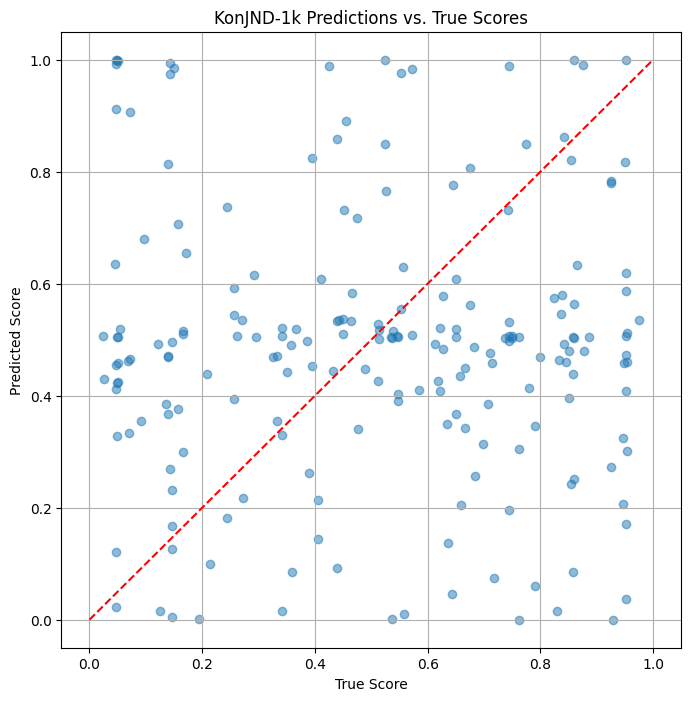


Final KonJND-1k Test Accuracy (Best Model): 0.3564

KonJND-1k Confusion Matrix (Raw Counts):
---------------------------------------------
           Predicted
           Low  Medium High
True Low     14   34     13  
True Medium  12   46     12  
True High    18   41     12  

KonJND-1k Confusion Matrix (Percentages):
-----------------------------------------------
               Predicted
             Low   Medium  High
True Low       0.23% 0.56% 0.21%
True Medium    0.17% 0.66% 0.17%
True High      0.25% 0.58% 0.17%


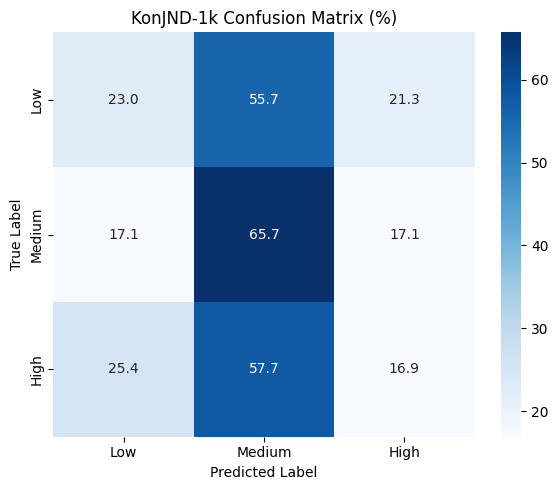


Starting evaluation on Samsung dataset...

Samsung Test Accuracy: 0.1719

Samsung Confusion Matrix (Raw Counts):
---------------------------------------------
           Predicted
           Low  Medium High
True Low     0    388    0   
True Medium  0    127    0   
True High    0    224    0   

Samsung Confusion Matrix (Percentages):
-----------------------------------------------
               Predicted
             Low   Medium  High
True Low       0.00% 1.00% 0.00%
True Medium    0.00% 1.00% 0.00%
True High      0.00% 1.00% 0.00%


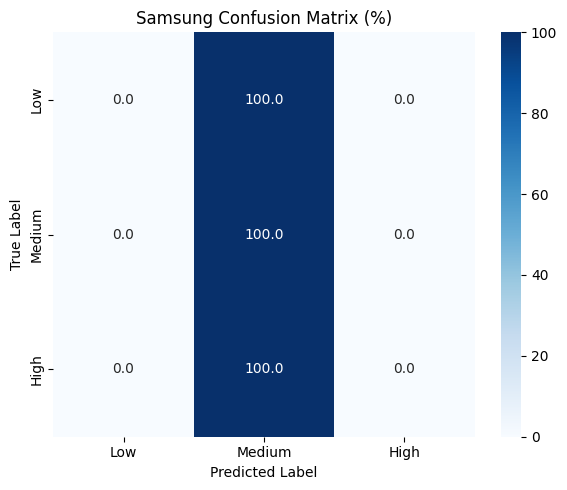

In [23]:
# -----------------------------
# Final Evaluation
# -----------------------------
print("Loading the best model for final evaluation...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# --- Evaluate on KonJND test set ---
konjnd_preds_scores, konjnd_targets_scores = [], []
with torch.no_grad():
    for imgs, scores in val_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        outputs = model(imgs)
        konjnd_preds_scores.extend(outputs.cpu().numpy())
        konjnd_targets_scores.extend(scores.cpu().numpy())

# Scatter plot of predictions vs. true scores
print("\nGenerating KonJND-1k prediction scatter plot...")
plt.figure(figsize=(8, 8))
plt.scatter(konjnd_targets_scores, konjnd_preds_scores, alpha=0.5)
plt.title("KonJND-1k Predictions vs. True Scores")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for perfect prediction
plt.grid(True)
plt.show()

# KonJND confusion matrix and accuracy
konjnd_preds_classes = [score_to_class(s) for s in konjnd_preds_scores]
konjnd_targets_classes = [score_to_class(s) for s in konjnd_targets_scores]
konjnd_accuracy = accuracy_score(konjnd_targets_classes, konjnd_preds_classes)
print(f"\nFinal KonJND-1k Test Accuracy (Best Model): {konjnd_accuracy:.4f}")

cm_konjnd = confusion_matrix(konjnd_targets_classes, konjnd_preds_classes, labels=[0, 1, 2])
print_confusion_matrix(cm_konjnd, "KonJND-1k")
plot_confusion_matrix(cm_konjnd, class_names=["Low", "Medium", "High"], dataset_name="KonJND-1k", normalize=True)


# --- Evaluate on Samsung test set ---
print("\nStarting evaluation on Samsung dataset...")
samsung_dataset = SamsungDataset(
    "Samsung/dataset/test_metadata.json",
    images_dir="Samsung/dataset",
    transform=common_transform,
)
samsung_loader = DataLoader(samsung_dataset, batch_size=32, shuffle=False)
samsung_preds_scores, samsung_targets_scores = [], []
with torch.no_grad():
    for imgs, scores in samsung_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        outputs = model(imgs)
        samsung_preds_scores.extend(outputs.cpu().numpy())
        samsung_targets_scores.extend(scores.cpu().numpy())
            
# Samsung confusion matrix and accuracy
samsung_preds_classes = [score_to_class(s) for s in samsung_preds_scores]
samsung_targets_classes = [score_to_class(s) for s in samsung_targets_scores]
samsung_accuracy = accuracy_score(samsung_targets_classes, samsung_preds_classes)
print(f"\nSamsung Test Accuracy: {samsung_accuracy:.4f}")
    
cm_samsung = confusion_matrix(samsung_targets_classes, samsung_preds_classes, labels=[0, 1, 2])
print_confusion_matrix(cm_samsung, "Samsung")
plot_confusion_matrix(cm_samsung, class_names=["Low", "Medium", "High"], dataset_name="Samsung", normalize=True)